# Compute RF Center Positions
Using STAs to generate center position for each neuron. A bit messy but it works!!!

September 4, 2024

In [1]:
import sys
import os

myhost = os.uname()[1]
print("Running on Computer: [%s]" %myhost)

sys.path.insert(0, '/home/ifernand/Code/') 
dirname = '/home/ifernand/Cloud_SynthData_Proj'

import numpy as np
from copy import deepcopy
import matplotlib.pyplot as plt
from scipy import io as sio
import torch
import time
import h5py

# NDN tools
import NDNT
import NDNT.utils as utils
from NDNT.modules.layers import *
from NDNT.networks import *
import NDNT.NDN as NDN
import NTdatasets.conway.multi_datasets as multidata
from NTdatasets.generic import GenericDataset
from ColorDataUtils.multidata_utils import MultiExperiment
import ColorDataUtils.ConwayUtils as CU
from ColorDataUtils import readout_fit
from ColorDataUtils.simproj_utils import *
from NDNT.utils import fit_lbfgs, fit_lbfgs_batch
from NDNT.utils import imagesc   
from NDNT.utils import ss

# Isabel Functions
from utils.data_class import SimCloudData

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device0 = torch.device("cpu")
dtype = torch.float32

%load_ext autoreload
%autoreload 2

Running on Computer: [sc]
Invoking __init__.py for NDNT.utils


## Create Data

In [8]:
DATADIR = '/home/ifernand/Cloud_SynthData_Proj/Antolik_Data/LSV1M_for_ML_MotionClouds/'
scale = 3

In [9]:
# List of all file names
file_names = []
for file_name in os.listdir(DATADIR):
    if file_name.startswith('motion'):
        file_scale = file_name[-5:-4]
        if scale is not None:
            if file_scale == str(scale):
                file_names.append(file_name[:-4])
        else:
            file_names.append(file_name[:-4])

file_names = file_names[:4]

N_files = len(file_names) # number of data files
print('Number of files', N_files)

Number of files 4


In [10]:
file_names

['motion_cloud_batch_length=20000_seed=6691_res=220_spatial_sca=3',
 'motion_cloud_batch_length=20000_seed=4385_res=220_spatial_sca=3',
 'motion_cloud_batch_length=20000_seed=6672_res=220_spatial_sca=3',
 'motion_cloud_batch_length=20000_seed=5242_res=220_spatial_sca=3']

In [11]:
# STIMULUS
# ========
file_start_pos = [0] # starting position for each data file in time searies
file_NT        = [] # number of time points in each file
for i in range(N_files):
    stim_i = np.load(DATADIR+file_names[i]+'.npy')
    file_NT.append(stim_i.shape[0])

    if i == 0:
        stim = stim_i
        file_start_pos.append(stim.shape[0])
    elif i == N_files-1:
        stim = np.append(stim, stim_i, axis=0)
    else:
        stim = np.append(stim, stim_i, axis=0)
        file_start_pos.append(stim.shape[0])
    print('File', i, 'stim added')
print('Stim shape', stim.shape)

File 0 stim added
File 1 stim added
File 2 stim added
File 3 stim added
Stim shape (80000, 220, 220)


In [6]:
stim = downsample_stim(stim, 2)
L = stim.shape[1]
print('Stim shape', stim.shape)

Stim shape (80000, 110, 110)


In [7]:
flat_stim = stim.reshape((stim.shape[0], int(L*L)))
print('Flat stim shape', flat_stim.shape)

Flat stim shape (80000, 12100)


In [22]:
# NEURON RESPONSES
# ================
cell_type_list = ['X_ON', 'X_OFF', 'V1_Exc_L4', 'V1_Inh_L4', 'V1_Exc_L2/3', 'V1_Inh_L2/3']
cell_NC = [7200,7200,37500,9375,37500,9375]

robs = np.zeros((flat_stim.shape[0],sum(cell_NC)))

for i in range(N_files):
    data_dict = list(np.load(DATADIR+'responses_'+file_names[i]+'.pickle', allow_pickle=True).values())[0]

    for j in range(len(cell_type_list)):
        start = time.time()
        cell_data = data_dict[cell_type_list[j]]
        print('Number of', cell_type_list[j], 'cells', cell_NC[j])
        
        for k in range(cell_NC[j]):
            robs[file_start_pos[i]:file_start_pos[i]+file_NT[i],sum(cell_NC[:j])+k] = np.histogram(cell_data[0,k], bins=file_NT[i], range=(0,int(16*file_NT[i])))[0]
        
        end = time.time()
        print('CPU Time', end-start, 'sec')
        print(' ')

    print('File', i, 'robs added')
    
print('Robs shape', robs.shape)

Number of X_ON cells 7200
CPU Time 4.201832294464111 sec
 
Number of X_OFF cells 7200
CPU Time 3.6742401123046875 sec
 
Number of V1_Exc_L4 cells 37500
CPU Time 16.218886852264404 sec
 
Number of V1_Inh_L4 cells 9375
CPU Time 5.0297346115112305 sec
 
Number of V1_Exc_L2/3 cells 37500
CPU Time 16.577918767929077 sec
 
Number of V1_Inh_L2/3 cells 9375
CPU Time 4.992650270462036 sec
 
File 0 robs added
Number of X_ON cells 7200
CPU Time 4.231338262557983 sec
 
Number of X_OFF cells 7200
CPU Time 3.7249348163604736 sec
 
Number of V1_Exc_L4 cells 37500
CPU Time 16.462878227233887 sec
 
Number of V1_Inh_L4 cells 9375
CPU Time 5.057784080505371 sec
 
Number of V1_Exc_L2/3 cells 37500
CPU Time 16.80912947654724 sec
 
Number of V1_Inh_L2/3 cells 9375
CPU Time 5.017247200012207 sec
 
File 1 robs added
Number of X_ON cells 7200
CPU Time 4.739918947219849 sec
 
Number of X_OFF cells 7200
CPU Time 4.212237119674683 sec
 
Number of V1_Exc_L4 cells 37500
CPU Time 17.467712879180908 sec
 
Number of V

In [23]:
out_file = 'data/cloud_data_for_computing_STA_RF_center.hdf5'
with h5py.File(out_file, 'w') as f:
    f.create_dataset('stim', data=(255*flat_stim).astype(np.uint8))
    f.create_dataset('robs', data=robs.astype(np.uint8))
    #f.create_dataset('cell_key', data=cell_key)

## Load Data

In [2]:
cell_type_list = ['X_ON', 'X_OFF', 'V1_Exc_L4', 'V1_Inh_L4', 'V1_Exc_L2/3', 'V1_Inh_L2/3']
cell_NC = [7200,7200,37500,9375,37500,9375]

In [12]:
out_file = 'data/cloud_data_for_computing_STA_RF_center.hdf5'
with h5py.File(out_file, 'r') as f:
    stim = f['stim'][:]
    robs = f['robs'][:]

In [26]:
#stim = (stim.astype(np.float32))/255
#robs = robs.astype(np.float32)
L = int(np.sqrt(stim.shape[1]))
NC = robs.shape[1]
print(stim.shape)
print(robs.shape)

(80000, 12100)
(80000, 108150)


In [7]:
stim_norm = (stim-np.mean(stim))/np.std(stim)

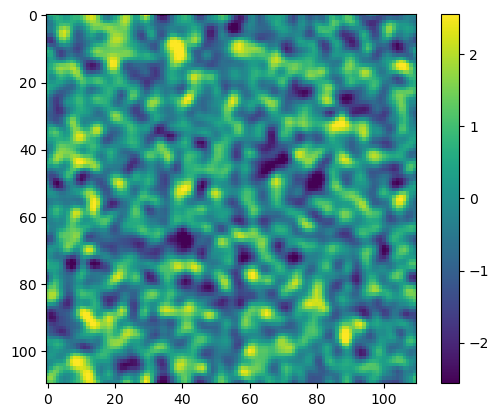

In [25]:
plt.imshow(stim_norm[5,:].reshape(L,L))
plt.colorbar()

## STA

In [13]:
num_lags = 12
dfs = np.ones(robs.shape)
for i in range(len(file_start_pos)):
    j = file_start_pos[i]
    dfs[j:j+num_lags,:] = 0

In [15]:
df_robs = robs*dfs
nspks = np.sum(robs,axis=0)

In [16]:
df_robs.shape

(80000, 108150)

In [18]:
NC = robs.shape[1]
sta_arr = np.zeros((2,L*L,NC))
for i in range(2):
    j = i+2
    start = time.time()
    sta_arr[i,:,:] = ((stim_norm[:-(j),:].T @ df_robs[j:,:])/nspks)
    end = time.time()
    print('Lag', j, 'complete')
    print('CPU Time', end-start, 'sec')

Lag 2 complete
CPU Time 145.6623296737671 sec
Lag 3 complete
CPU Time 145.55889296531677 sec


In [19]:
print('STA array shape:', sta_arr.shape)

STA array shape: (2, 12100, 108150)


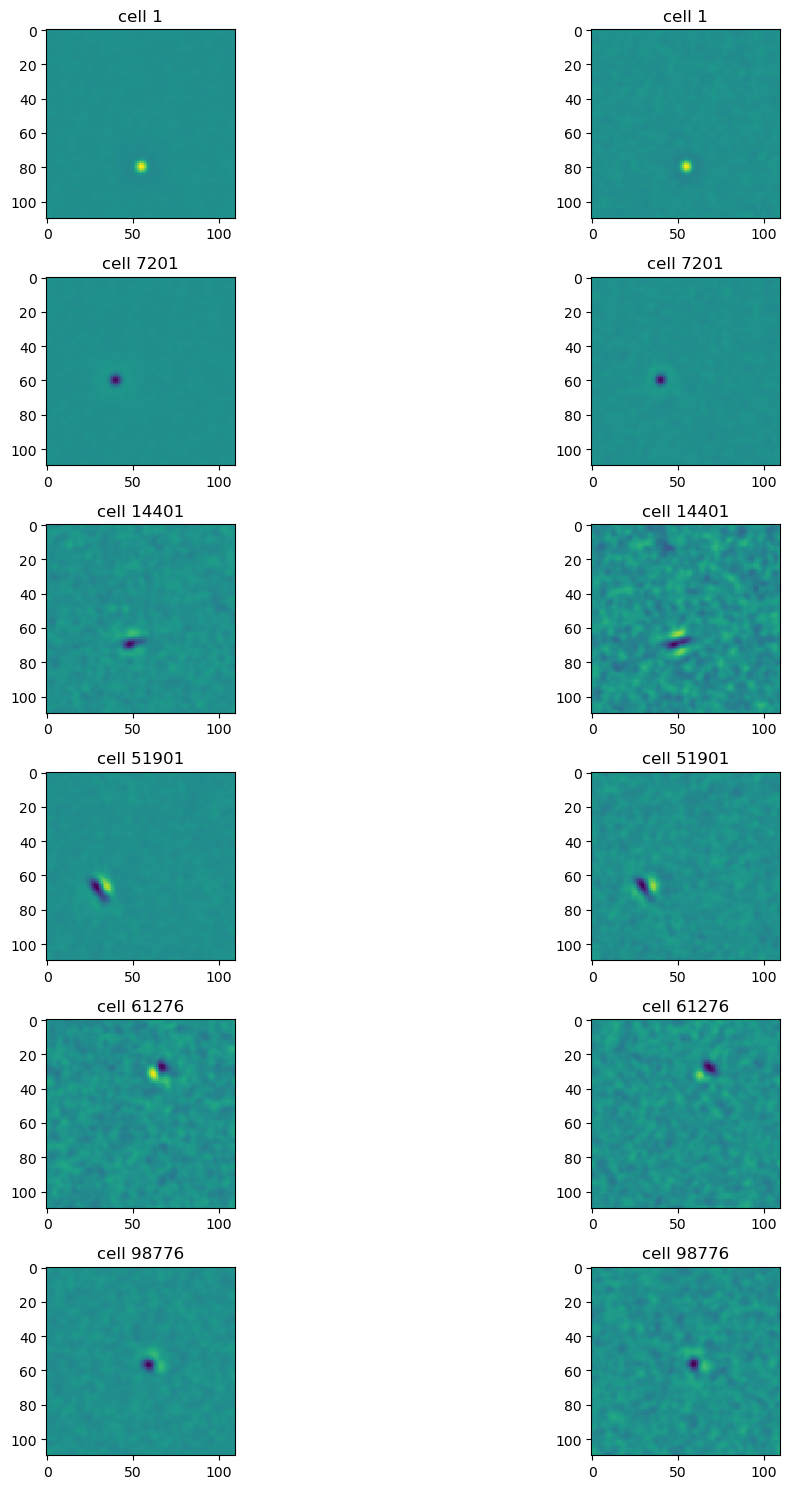

In [20]:
ss(6,2)
k = 1
for i in range(6):
    for j in range(2):
        plt.subplot(6,2,k)
        l = sum(cell_NC[:i])+1
        imagesc(sta_arr[j,:,l].reshape(L,L))
        plt.title('cell '+str(l))
        k += 1
plt.tight_layout()
plt.show()

In [23]:
sta_arr_int8 = ((sta_arr-np.min(sta_arr))/(np.max(sta_arr)-np.min(sta_arr)))*255

In [39]:
np.save('data/all_cell_STA_lag_2-3.npy', sta_arr[[1,2],:,:])

OSError: Not enough free space to write 20937840000 bytes

## Compute RF Centers

* Measure centers using max
* Use STAs
* Take variance across time
* Take the max or average psition or RF utils

In [28]:
sta_var = np.zeros((L*L,NC))
for i in range(len(cell_type_list)):
    sta_var[:,sum(cell_NC[:i]):sum(cell_NC[:i])+cell_NC[i]] = np.var(sta_arr[:,:,sum(cell_NC[:i]):sum(cell_NC[:i])+cell_NC[i]], axis=0)
    print(cell_type_list[i], 'varaince complete')

X_ON varaince complete
X_OFF varaince complete
V1_Exc_L4 varaince complete
V1_Inh_L4 varaince complete
V1_Exc_L2/3 varaince complete
V1_Inh_L2/3 varaince complete


In [31]:
sta_var = sta_var.reshape(L,L,NC)
print('STA var shape:',sta_var.shape)

STA var shape: (110, 110, 108150)


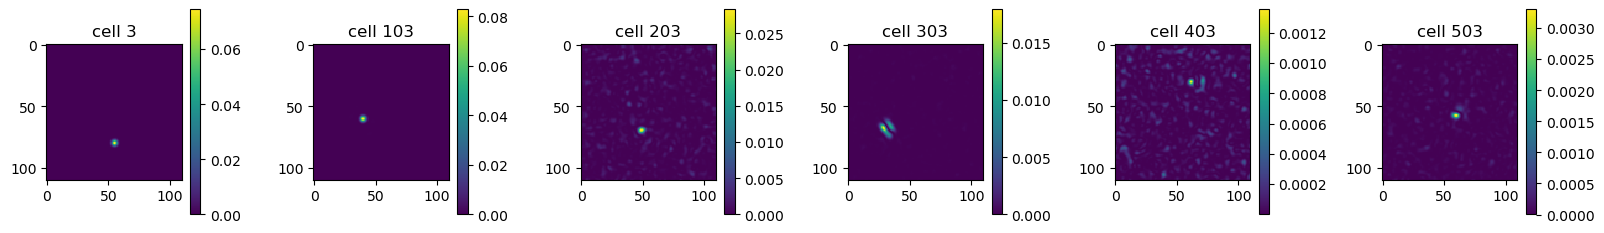

In [33]:
ss(1,6)
for i in range(6):
    plt.subplot(1,6,i+1)
    l = sum(cell_NC[:i])+1
    imagesc(sta_var[:,:,l])
    plt.title('cell '+str(i*100+3))
    plt.colorbar()
plt.tight_layout()
plt.show()

In [34]:
rf_center = np.zeros((2,NC))
for i in range(NC):
    aux = np.unravel_index(np.argmax(sta_var[:,:,i]), (L,L))
    rf_center[0,i] = aux[0]
    rf_center[1,i] = aux[1]
print('RF center arr shape:', rf_center.shape)

RF center arr shape: (2, 108150)


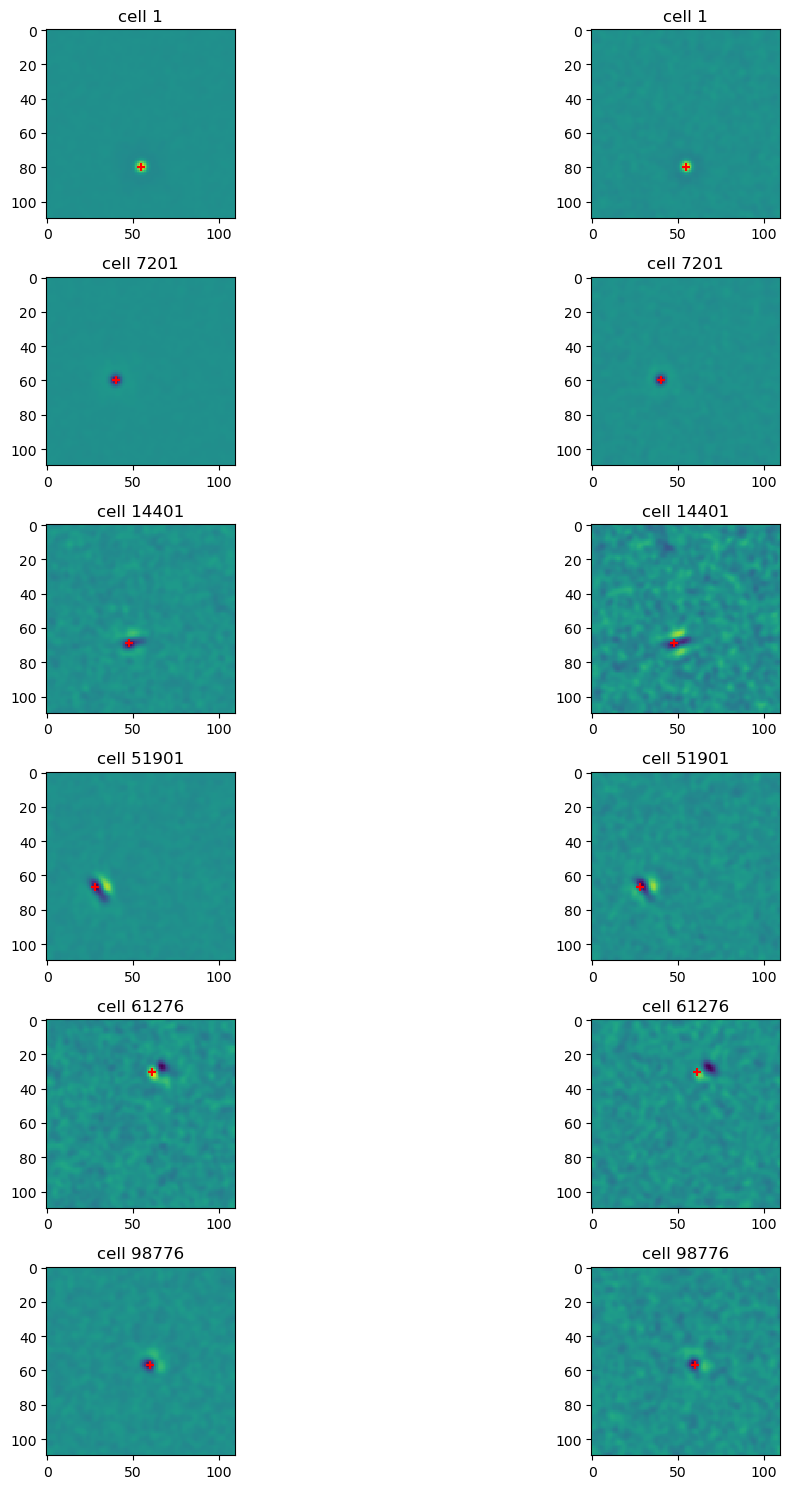

In [36]:
ss(6,2)
k = 1
for i in range(6):
    for j in range(2):
        l = sum(cell_NC[:i])+1
        plt.subplot(6,2,k)
        imagesc(sta_arr[j,:,l].reshape(L,L))
        plt.scatter(rf_center[0,l],rf_center[1,l],c='r',s=40,marker='+')
        plt.title('cell '+str(l))
        k += 1
plt.tight_layout()
plt.show()

In [37]:
deg_RF_center = (rf_center-(L//2))/10

In [40]:
center_dict = {}
for i in range(len(cell_type_list)):
    center_dict[cell_type_list[i]] = deg_RF_center[:,sum(cell_NC[:i]):sum(cell_NC[:i])+cell_NC[i]]

In [42]:
center_dict['X_ON'].shape

(2, 7200)

In [39]:
np.save('data/all_neuron_RF_centers_in_deg.npy',deg_RF_center)

In [44]:
import pickle
with open('data/all_neuron_RF_centers_in_deg.pkl', 'wb') as f:
    pickle.dump(center_dict, f)